Homework 6 <br>
Sam Odle

In [37]:
import torch
from torch.backends import cudnn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
from torch import nn, optim
import torch.nn.functional as F
import random
import warnings
import argparse

GPU Implementation (partial)

In [38]:
if False:
    parser = argparse.ArgumentParser(description='PyTorch Image Training')
    args = parser.parse_args()

    if args.seed is not None:
        random.seed(args.seed)
        torch.manual_seed(args.seed)
        cudnn.deterministic = True

    if args.gpu is not None:
        warnings.warn('You have chosen a specific GPU. This will completely '
                          'disable data parallelism.')

### Download the Fashion MNIST dataset

And convert it into a format (a tensor) that pytorch understands. A tensor can be thought of as matrix (you get to define the dimensions).

Feed the raw images and their labels into a DataLoader that will serve them up in batches to train the model.

In [39]:
# Define a transform for the data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

### View a sample image and label
We need to reshape the tensor and feed those pixels into a display library

Label of image tensor(7)
(1, 28, 28)


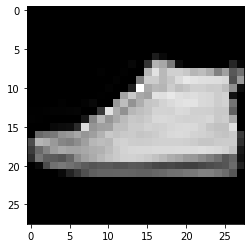

In [40]:
tensor_image, label = next(iter(trainloader)) # returns a batch of images
print("Label of image", label[0])
first_image = numpy.array(tensor_image, dtype='float')[0] # get the first image in the batch
print(first_image.shape)
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

### Define your model
We will have three hidden layers, an input later, and then an output layer. All nodes are Linear nodes (using linear activation).

The input layer takes 784 == 28x28 features, corresponding to our greyscale input images.
The three hidden layers have 256, 128, and 64 neurons respectively; each previous layer's neurons all feed into each neuron in the next layer ("fully connected").
The final layer has ten neurons, one representing each of the ten possible classes for this model.

Under the forward method, we define the activation function for each later: we're using ReLu for all the hidden layers. In the last layer, we're switching to softmax so we can get the probabilities for each class.

In [41]:
# Define your network architecture here
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1) # -1 means we'll let the computer figure out how many rows to include
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(self.fc4(x), dim=1)
        
        return x

### Training the model
We choose a learning rate (lr) and some number of epochs, with the goal that the loss is going down each epoch until model convergence on the minimum loss (estimated).

In [42]:
# store train and validation loss in separate arrays, one for each epoch, and graph this!! be careful about eval vs train mode

# Create the custom network above, define the loss criterion, and choose an optimizer to learn weights
model = Classifier()
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.3)

# Train the network here
epochs = 9

val_losses = []
train_losses = []

for e in range(epochs):
    print("In epoch", e)
    running_loss = 0
    for images, labels in trainloader: # processing one batch at a time
        predictions = model(images) # predict labels
        loss = loss_criterion(predictions, labels) # calculate the loss

        if torch.cuda.is_available():
            target = target.cuda(args.gpu, non_blocking=True)

        # BACK PROPAGATION OF LOSS to generate updated weights
        optimizer.zero_grad() # pytorch accumulates gradients from previous backwards
                              # passes by default -- we want to zero them out;
                              # you can read online why they have this implementation choice
        loss.backward() # compute gradients by using the predictions' grad_fn
                        # that was passed to loss_criterion() above -- this is how it
                        # knows what model parameters need updating eventually
                        # (this is confusing IMO and not obvious to those used to OOP)
        optimizer.step() # using gradients just calculated for model parameters, 
                         # update the weights via the optimizer (which was init with those 
                         # model parameters)

        running_loss += loss.item()

        tensor_images_V, labels_V = next(iter(testloader)) # returns a batch of images
        predictions_V = model(tensor_images_V) # predict labels
        loss_V = loss_criterion(predictions_V, labels_V) # calculate the loss
        val_losses.append(loss_V.item())

        train_losses.append(loss.item())

    print(f"\tTraining loss: {running_loss/len(trainloader)}")

In epoch 0
	Training loss: 1.8586945449873837
In epoch 1
	Training loss: 1.733887351779287
In epoch 2
	Training loss: 1.7245570036139823
In epoch 3
	Training loss: 1.7197802118909384
In epoch 4
	Training loss: 1.7164582903705425
In epoch 5
	Training loss: 1.7135236094247048
In epoch 6
	Training loss: 1.7112823304082794
In epoch 7
	Training loss: 1.662313138498172
In epoch 8
	Training loss: 1.6498768985398542


## Graph of Training & Validation Loss

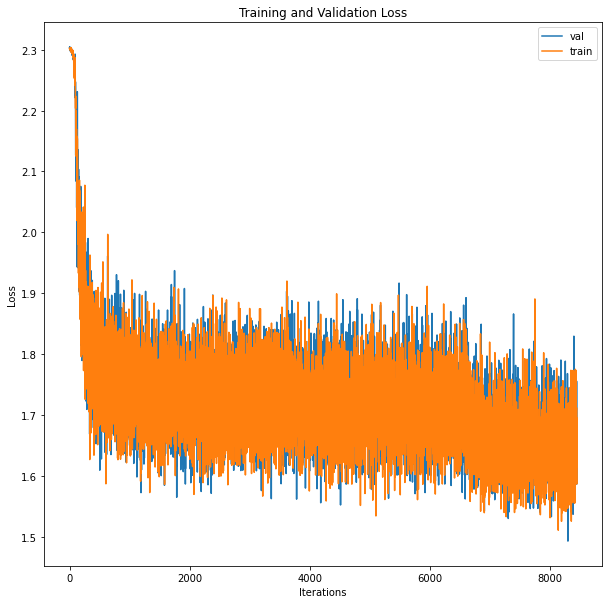

In [43]:
plt.figure(figsize=(10,15))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()



### Making predictions
Once we've trained the model, we can grab an image and pull out information about its predicted class.

Target label of image:  tensor(0)
(1, 28, 28)


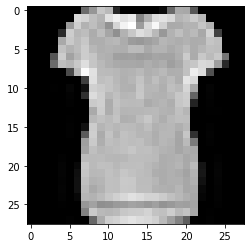

tensor([[1.0000e+00, 2.5166e-27, 5.2751e-15, 7.2731e-16, 5.2009e-29, 3.0121e-27,
         3.3228e-24, 3.3731e-33, 1.3885e-27, 5.2951e-30]],
       grad_fn=<SoftmaxBackward>)
max_prob 1.0
Predicted label:  0
Target label:  0
Successful prediction!


In [44]:
# Test the trained model
tensor_image, label = next(iter(testloader)) # returns a batch of images
print("Target label of image: ", label[0])
first_image = numpy.array(tensor_image, dtype='float')[0] # get the first image in the batch
print(first_image.shape)
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

prediction = model(tensor_image[0])
print(prediction)
prediction = prediction.detach().numpy()
max_prob = max(list(numpy.array(prediction)[0]))
print('max_prob', max_prob)
predicted_label = list(prediction[0]).index(max_prob)
print("Predicted label: ", predicted_label)

tgt_lbl = label[0].item()
print("Target label: ", tgt_lbl)

if tgt_lbl == predicted_label:
    print("Successful prediction!")
else:
    print("Not quite...")

### Accuracy for each batch

In [45]:
# Test the trained model
tensor_image, label = next(iter(testloader)) # returns a batch of images

correct = 0
incorrect = 0

for i in range(len(label.tolist())):
    first_image = numpy.array(tensor_image, dtype='float')[i] # get the first image in the batch

    prediction = model(tensor_image[i])
    prediction = prediction.detach().numpy()
    max_prob = max(list(numpy.array(prediction)[0]))
    predicted_label = list(prediction[0]).index(max_prob)

    if label[i].item() == predicted_label:
        correct += 1
        print('+', end = '')
    else:
        incorrect += 1
        print(predicted_label, end = '') #let's take a look at what we're missing

accuracy = round(correct * 100 / (correct + incorrect), 2)
print('')
print(f'Accuracy: {accuracy}% for {correct + incorrect} images.')

+++4+++++++++0++++304++++++4++++++2+0++++++3+++2+++++4+7+++++7++
Accuracy: 79.69% for 64 images.


### Playground

What happens when you: <br>
 <br>**1. Use a much smaller learning rate for the model?** <br>
    Using the initial learning rate of 0.3, the model settles into a loss of ~1.7 after 7/8 epochs. <br>
User larger learning rates (around 0.5), the lost evens out quicker but appears to remain more variable after the mean appears to stabilize.

<br> <br>**2. Feed in the entire test dataset to the model, to make predictions? Could you write code to do this, and measure your model performance?** <br>

In [46]:
# Test on ALL the images
#tensor_image, label = next(iter(testloader)) # returns a batch of images

correct_net = 0
incorrect_net = 0

for imagesX, labelsX in testloader:
    print('')
    for i in range(len(labelsX.tolist())):
        first_image = numpy.array(imagesX, dtype='float')[i] # get the ith image in the batch

        prediction = model(imagesX[i])
        prediction = prediction.detach().numpy()
        max_prob = max(list(numpy.array(prediction)[0]))
        predicted_label = list(prediction[0]).index(max_prob)

        print(f' {label[i].item()}/{predicted_label}', end = '')

        if label[i].item() == predicted_label:
            correct_net += 1
            #print('+', end = '')
        else:
            incorrect_net += 1
            #print(predicted_label, end = '') #let's take a look at what we're missing


accuracy_net = round(correct_net * 100 / (correct_net + incorrect_net), 2)
print('')
print(f'Accuracy: {accuracy_net}% for {correct_net + incorrect_net} images.')


 9/2 3/9 0/9 6/2 8/8 5/9 7/0 9/9 3/1 8/2 1/7 4/1 5/5 6/7 7/9 5/8 5/2 5/7 0/4 6/2 6/7 0/2 3/5 7/1 9/9 1/0 1/7 3/0 9/7 5/3 4/0 3/5 8/5 3/8 4/9 2/7 6/0 9/0 2/4 0/2 3/9 8/4 3/7 8/2 8/8 7/4 5/4 6/1 3/2 7/7 2/2 7/5 9/2 6/2 4/5 9/5 2/0 5/3 1/8 3/5 2/7 5/0 8/2 5/0
 9/4 3/5 0/7 6/3 8/8 5/3 7/9 9/3 3/9 8/3 1/7 4/9 5/9 6/3 7/2 5/0 5/8 5/8 0/0 6/0 6/0 0/7 3/7 7/9 9/2 1/7 1/0 3/5 9/8 5/1 4/0 3/4 8/0 3/3 4/2 2/7 6/7 9/8 2/2 0/1 3/1 8/9 3/3 8/3 8/4 7/5 5/3 6/7 3/4 7/4 2/9 7/8 9/5 6/2 4/0 9/7 2/5 5/4 1/4 3/3 2/3 5/3 8/0 5/8
 9/3 3/1 0/4 6/0 8/1 5/9 7/9 9/2 3/7 8/4 1/2 4/7 5/9 6/4 7/3 5/9 5/3 5/8 0/3 6/3 6/2 0/3 3/1 7/1 9/0 1/8 1/1 3/9 9/4 5/7 4/2 3/4 8/8 3/7 4/5 2/9 6/8 9/9 2/2 0/3 3/0 8/0 3/1 8/9 8/7 7/0 5/1 6/9 3/4 7/0 2/3 7/4 9/2 6/1 4/5 9/2 2/4 5/2 1/8 3/9 2/3 5/5 8/4 5/4
 9/4 3/3 0/9 6/4 8/5 5/3 7/0 9/1 3/0 8/2 1/0 4/5 5/4 6/8 7/9 5/0 5/5 5/5 0/5 6/4 6/9 0/1 3/1 7/2 9/2 1/4 1/2 3/3 9/2 5/4 4/1 3/1 8/9 3/1 4/2 2/2 6/2 9/3 2/3 0/3 3/5 8/4 3/7 8/0 8/1 7/4 5/9 6/7 3/3 7/9 2/3 7/1 9/2 6/4 4/7 9/7 2/3

  <br> <br>**3. Train the model on only one epoch?** <br>
Training the model on only one epoch results in even higher loss & likely some gross underfitting.